**Question 1**

We discussed in class the *Spectral Line Problem* for the data shown in Figure 3.3
and Table 3.1 of our textbook. We computed the unnormalized posterior PDF for the line
strength $T$ , assuming model $M_1$, and got results that match the curves shown in Figure 3.6
for the uniform and Jeffreys priors.

(a) (2 pts) Calculate $p(D|M_1, I)$ for the uniform and Jeffreys prior cases. The numerical
answers are given in (3.45) and (3.47), respectively. There are typos, however, in both
equations (see errata), but the numerical answers are correct. To carry out the integrals,
you can use simple numerical integrators such as `np.trapz` or one of the ”fixed-samples”
methods in `scipy.integrate`.

(b) (2 pts) Calculate the odds ratio $O_{12}$ (Equation 3.31) for the uniform and Jeffreys prior
cases. The numerical answer is given in the text on page 58.

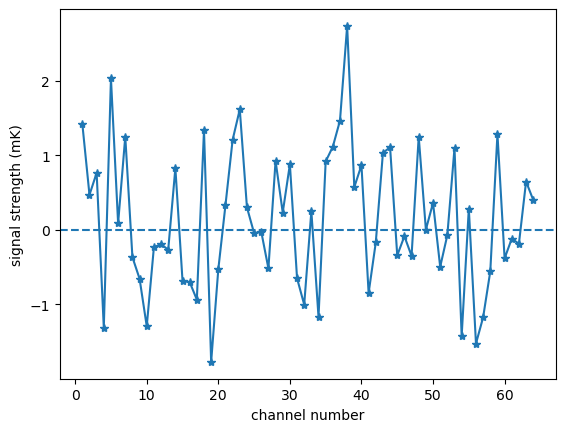

In [1]:
# Copied from SpectralLine1.ipynb

import numpy as np
import matplotlib.pyplot as plt
import scipy

data1 = np.genfromtxt('SpectralLine1.dat')
nu = data1[:, 0]
signal = data1[:, 1]

def plot_spectrum(nu, signal):
    plt.plot(nu, signal, marker='*')
    plt.axhline(y=0, linestyle="--")
    plt.xlabel("channel number")
    plt.ylabel("signal strength (mK)")
    
plot_spectrum(nu, signal)
plt.show()

In [2]:
# Also copied from SpectralLines1.ipynb
def model1(nu, T, nu0=37.0, sigL=2.0):
    """The prediction of model M1 given an array of channel numbers (nu) and
    a specific choice of T for the amplitude of the signal.
    """
    S = T*np.exp(-((nu-nu0)**2)/(2*sigL**2))
    return S

def model2(nu):
    """The prediction of model M2 given an array of channel numbers (nu).
    """
    S = np.zeros_like(nu)  # because we want all the values for each nu
    # S = 0.0*nu           # this should also work
    return S

In [3]:
# Question 1a

def calculate_m1_likelihood_T(nu, signal, T, sigma=1):
    """Calculate p(D|M1, T, I) for a particular value of T, assuming the noise in the data 
    is Gaussian with standard deviation, sigma.
    """
    ### BEGIN SOLUTION
    # p(D|T) = (2pi sigma^2)^-N exp(-sum_i((data_i - model1_i(T))^2/(2*sigma^2))

    pDT = np.exp(-np.sum((signal - model1(nu, T))**2 / (2*sigma**2)))
    pDT /= (2.*np.pi * sigma**2)**(len(signal)/2)
    return pDT
    ### END SOLUTION
    
def calculate_m1_likelihood(nu, signal, prior, sigma=1, Tmin=0.1, Tmax=100):
    """Calculate p(D|M1, I) assuming the noise in the data is Gaussian with standard deviation, sigma.
    
    If prior is 'uniform', use a uniform prior on T between Tmin and Tmax,
    If prior is 'Jeffreys', use a Jeffreys prior on T between Tmin and Tmax,
    """
    ### BEGIN SOLUTION
    
    # p(D|M1,I) = int dT p(T) p(D|T)
    # p(T) = 1/(100-0.1)
    # p(D|T) = (2pi sigma^2)^-N exp(-sum_i((data_i - model_i(T))^2/(2*sigma^2))
    
    # Choose a good range of T values to use.
    T = np.linspace(Tmin, Tmax, 5000)
    
    if prior == 'uniform':
        pT = np.ones_like(T) / (Tmax-Tmin)
    else:
        pT = np.ones_like(T) / (T * np.log(Tmax/Tmin))

    # Find p(D|T) for each T in the array
    pDT = np.empty(T.shape)
    for i, Ti in enumerate(T):
        pDT[i] = calculate_m1_likelihood_T(nu, signal, Ti, sigma=sigma)

    # Integrate P(D|T) P(T) dT
    return np.trapz(pDT * pT, T)
    ### END SOLUTION

In [4]:
p_m1_uniform = calculate_m1_likelihood(nu, signal, 'uniform')
print(f'Uniform prior: p(D|M1,I) = {p_m1_uniform}')

# The book claims this answer is 1.131e-38
assert np.isclose(p_m1_uniform, 1.131e-38, rtol=0.001, atol=0)

p_m1_Jeffreys = calculate_m1_likelihood(nu, signal, 'Jeffreys')
print(f'Jeffreys prior: p(D|M1,I) = {p_m1_Jeffreys}')

# The book claims this answer is 1.239e-37
assert np.isclose(p_m1_Jeffreys, 1.239e-37, rtol=0.001, atol=0)


### BEGIN HIDDEN TESTS
# This code snippet lets us just log the test failures so we can see all the things that fail, rather than
# bomb out on the first failure.  Then at the end, we just assert that there were 0 failures to get the
# automatic grading to give points.
nfail=0
from contextlib import contextmanager
import traceback
@contextmanager
def log_assert():
    global nfail
    try:
        yield
    except AssertionError as e:
        print('Failed assert:')
        print(traceback.format_exception(e)[-2].split('\n')[1])
        print('    msg =',str(e))
        nfail += 1
        
# Mostly just make sure they actually did the calculation, not just return the right answer somehow.
# So check that if we change the input in various ways, the returned answer changes appropriately.
# True values are all from the solution code.

# If signal doubles, likelihood gets much worse (since exp(-signal^2) dominates)
p1u = calculate_m1_likelihood(nu, 2*signal, 'uniform')
true_p1u = 2.962959809899265e-70
with log_assert():
    assert np.isclose(p1u, true_p1u, rtol=0.001, atol=0), (p1u, true_p1u)

p1j = calculate_m1_likelihood(nu, 2*signal, 'Jeffreys')
true_p1j = 1.4161215018286705e-69
with log_assert():
    assert np.isclose(p1j, true_p1j, rtol=0.001, atol=0), (p1j, true_p1j)

# If sigma doubles, it's also worse (because of sigma^-N factor)
p2u = calculate_m1_likelihood(nu, signal, 'uniform', sigma=2)
true_p2u = 8.86730871247274e-50
with log_assert():
    assert np.isclose(p2u, true_p2u, rtol=0.001, atol=0), (p2u, true_p2u)

# If T range is tighter around correct answer, likelihood is a bit better.
p3u = calculate_m1_likelihood(nu, signal, 'uniform', Tmin=1, Tmax=2)
true_p3u = 7.376259313748938e-37
with log_assert():
    assert np.isclose(p3u, true_p3u, rtol=0.001, atol=0), (p3u, true_p3u)

# If T range is tighter, not including correct answer, likelihood is much worse.
p4u = calculate_m1_likelihood(nu, signal, 'uniform', Tmin=10, Tmax=20)
true_p4u = 4.321764855194974e-94
with log_assert():
    assert np.isclose(p4u, true_p4u, rtol=0.001, atol=0), (p4u, true_p4u)

# If nu range is tighter around correct answer, likelihood is better.
p5u = calculate_m1_likelihood(nu[35:40], signal[35:40], 'uniform')
true_p5u = 5.358235394391817e-05
with log_assert():
    assert np.isclose(p5u, true_p5u, rtol=0.001, atol=0), (p5u, true_p5u)

# If nu range is tighter, not including correct answer, likelihood is even better.
# This is counter intuitive, but it's because the model is basically 0 for this whole
# range, so the model is very good for all T values.
p6u = calculate_m1_likelihood(nu[:5], signal[:5], 'uniform')
true_p6u = 0.00013344526475627378
with log_assert():
    assert np.isclose(p6u, true_p6u, rtol=0.001), (p6u, true_p6u)

print(f"\nTotal of {nfail} test failures")
assert nfail == 0
### END HIDDEN TESTS

Uniform prior: p(D|M1,I) = 1.1320444488571345e-38
Jeffreys prior: p(D|M1,I) = 1.239110679329912e-37

Total of 0 test failures


In [5]:
def calculate_m2_likelihood(nu, signal, sigma=1):
    """Calculate p(D|M2, I) assuming the noise in the data is Gaussian with standard deviation, sigma.
    """
    ### BEGIN SOLUTION
    
    # There is no T range to integrate over this time, so this is much simpler.
    # p(D|T) = (2pi sigma^2)^-N exp(-sum_i((data_i - model2_i^2/(2*sigma^2))

    pD = np.exp(-np.sum((signal - model2(nu))**2 / (2*sigma**2)))
    pD /= (2.*np.pi * sigma**2)**(len(signal)/2)
    return pD
    ### END SOLUTION
    
def calculate_odds(p1, p2):
    """Calculate the odds ratio given the likelihood of two models.
    """
    ### BEGIN SOLUTION
    return p1/p2
    ### END SOLUTION

In [6]:
p_m2 = calculate_m2_likelihood(nu, signal)

odds_uniform = calculate_odds(p_m1_uniform, p_m2)
odds_Jeffreys = calculate_odds(p_m1_Jeffreys, p_m2)
print(f'Odds ratio for uniform prior is {odds_uniform}')
print(f'Odds ratio for Jeffreys prior is {odds_Jeffreys}')

# The book claims these are 0.9986 and 10.94
assert np.isclose(odds_uniform, 0.9986, rtol=0.001)
assert np.isclose(odds_Jeffreys, 10.94, rtol=0.001)

### BEGIN HIDDEN TESTS
nfail=0

# If signal doubles, likelihood again gets much worse
p1 = calculate_m2_likelihood(nu, 2*signal)
true_p1 = 6.949981115984018e-76
with log_assert():
    assert np.isclose(p1, true_p1, rtol=0.001, atol=0), (p1, true_p1)

# Also if sigma doubles
p2 = calculate_m2_likelihood(nu, signal, sigma=2)
true_p2 = 1.2339802343108764e-48
with log_assert():
    assert np.isclose(p2, true_p2, rtol=0.001, atol=0), (p2, true_p2)

# If nu range is tighter around correct answer, likelihood is better.
p3 = calculate_m2_likelihood(nu[35:40], signal[35:40])
true_p3 = 2.6107010817112155e-05
with log_assert():
    assert np.isclose(p3, true_p3, rtol=0.001, atol=0), (p3, true_p3)

# If nu range is tighter, not including correct answer, likelihood is even better.
# Note that this is numerically equal to the M1 value, since the two models are
# essentially equivalent for these channels.
p4 = calculate_m2_likelihood(nu[:5], signal[:5])
print(p4)
true_p4 = 0.00013344526475627378
with log_assert():
    assert np.isclose(p4, true_p4, rtol=0.001), (p4, true_p4)

print(f"\nTotal of {nfail} test failures")
assert nfail == 0
### END HIDDEN TESTS

Odds ratio for uniform prior is 0.9992736000665501
Odds ratio for Jeffreys prior is 10.937826608000737
0.00013344526475627378

Total of 0 test failures


**Question 2**

In this problem, we will simulate another data set that resembles the one shown
in Figure 3.7, which has a higher line strength than the first example.

(a) (2 pts) Taking $T = 5.0$ mK, simulate a new dataset $D^\prime$ by sampling the signal in each
channel from a normal (gaussian) distribution with a mean given by the model and
$\sigma = 1.0$ mK. You can use np.random.normal to sample from a normal distribution.
Plot the new dataset and confirm that it roughly resembles the left panel of Figure 3.7.

(b) (2 pts) Using the Jeffreys prior for $T$ in the range $0.1 \le T \le 100$ mK,
calculate the posterior PDF $p(T |D^\prime, M_1, I)$ and the 95% credible region for $T$.
Make a plot of $p(T |D^\prime, M_1, I)$ vs $T$.

(c) (2 pts) Calculate the new odds ratio $O_{12}^\prime$

In [7]:
# Question 2a

def simulate_spectrum(nu, T=5.0, sigma=1):
    """Simlulate a specturm of the M1 model for the given channels (nu), assuming the signal strength
    is T and the noise in the data is sigma.
    
    Returns an array of simulated signal values.
    """
    ### BEGIN SOLUTION
    signal = model1(nu, T)
    signal += np.random.normal(0, sigma, nu.shape)
    return signal
    ### END SOLUTION


Total of 0 test failures


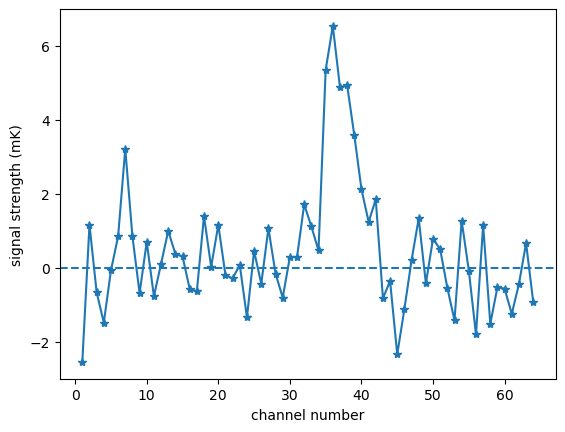

In [8]:
sim = simulate_spectrum(nu)

plot_spectrum(nu, sim)

### BEGIN HIDDEN TESTS
nfail=0

with log_assert():
    assert len(sim) == 64, len(sim)

with log_assert():
    assert 3.5 < np.max(sim) < 7.5, np.max(sim)

with log_assert():
    assert 32 < np.argmax(sim) < 42, np.max(sim)

print(f"\nTotal of {nfail} test failures")
assert nfail == 0
### END HIDDEN TESTS

In [9]:
# Question 2b

def calculate_m1_T_posterior(nu, signal, sigma=1, Tmin=0.1, Tmax=100):
    """Calculate the posterior PDF for T, p(T|D',M1,I) in the M1 model, assuming a Jeffreys prior on T.
    
    Returns T, p(T|D',M1,I) (both numpy arrays; they should be the same length)
    """
    ### BEGIN SOLUTION
    T = np.linspace(Tmin, Tmax, 5000)
    pT = np.ones_like(T) / (T * np.log(Tmax/Tmin))

    # Again calculate p(D|T)
    pDT = np.empty(T.shape)
    for i, Ti in enumerate(T):
        pDT[i] = calculate_m1_likelihood_T(nu, signal, Ti, sigma=sigma)
    
    # Bayes formula:
    # P(T|D) = P(D|T) P(T) / P(D)
    pTD = pDT * pT
    
    # Denominator is just normalization to make integral = 1.
    pTD /= np.trapz(pTD, T)
    return T, pTD
    ### END SOLUTION
    
def calculate_m1_T_95(T, pdf, C=0.95):
    """Calculate the 95% confidence interval for the given pdf
    
    Returns (T1, T2) being the limits of the confidence interval.
    """
    ### BEGIN SOLUTION
    
    # Copied from HW1 solution (but change H to T)
    def find_T_at_cdf(target):
        # This is a little helper function to find the H value corresponding to where 
        # the cdf equals the given target value. 
        # We'll use it for median, lower, and upper (with target = 0.5, 0.05, 0.95 respectively).
        i = np.searchsorted(cdf, target)
        assert cdf[i-1] <= target <= cdf[i]
        
        # At this point, an approximate answer could be just
        #     return H[i]
        # However, we can refine it slightly for more accuracy.
        return (T[i-1] * (cdf[i]-target) + T[i] * (target-cdf[i-1])) / (cdf[i]-cdf[i-1])
    
    cdf = scipy.integrate.cumtrapz(pdf, T, initial=0)
    T1 = find_T_at_cdf((1-C)/2)
    T2 = find_T_at_cdf(1-(1-C)/2)
    return T1, T2
    ### END SOLUTION

In [10]:
T, p_T_sim = calculate_m1_T_posterior(nu, sim)

print(f'Maximum posterior is at T = {T[np.argmax(p_T_sim)]:.2f} mK')

T1, T2 = calculate_m1_T_95(T, p_T_sim)
print(f'95% confidence interval: [{T1}, {T2}]')

### BEGIN HIDDEN TESTS
nfail=0

# Check that T is sorted.
with log_assert():
    assert np.all(T[:-1] < T[1:]), ('T is not sorted', T)
# Check that T range encompases T=5.
with log_assert():
    assert T[0] < 4, T[0]
with log_assert():
    assert T[-1] > 6, T[-1]
# Check that used reasonable number of points near right answer
with log_assert():
    assert np.sum((4 <= T) & (T <= 6)) >= 10, np.sum(4 < T < 6)

# Check that pdf is normalized
with log_assert():
    assert np.isclose(np.trapz(p_T_sim, T), 1.0, rtol=1.e-3), np.trapz(p_T_sim, T)

# Check that pdf is calculated correctly given T.
true_p_T = np.empty(T.shape)
for i, Ti in enumerate(T):
    true_p_T[i] = calculate_m1_likelihood_T(nu, sim, Ti) / Ti
true_p_T /= np.trapz(true_p_T, T)
with log_assert():
    w = np.where(np.abs(p_T_sim-true_p_T) > 0.01 * np.abs(true_p_T))
    assert np.allclose(p_T_sim, true_p_T, rtol=0.01, atol=1.e-6), (p_T_sim[w], true_p_T[w])

# Usually T1 < 5 < T2, but that should fail about 1 in 20 times.  So use wider range for test.
with log_assert():
    assert T1 < 6, T1
with log_assert():
    assert 4 < T2, T2
with log_assert():
    assert T1 < T2

# Check that integral is close to 0.95
i1 = np.searchsorted(T, T1)
i2 = np.searchsorted(T, T2)
int_T1_T2 = np.trapz(p_T_sim[i1:i2], T[i1:i2])
with log_assert():
    assert np.isclose(int_T1_T2, 0.95, atol=0.02), int_T1_T2

print(f"\nTotal of {nfail} test failures")
assert nfail == 0
### END HIDDEN TESTS

Maximum posterior is at T = 6.10 mK
95% confidence interval: [5.041668175220116, 7.132296819530798]

Total of 0 test failures


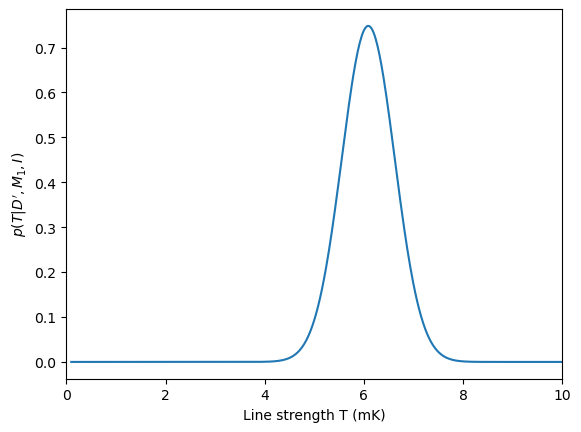

In [11]:
# Question 2b, continued

def plot_T_posterior(T, pdf):
    """Plot the posterior probability distribution function (pdf) of T in model M1 for the simulation.
    """
    # Hint: Make sure to pick a reasonable range for the axes, and label your axes.
    
    ### BEGIN SOLUTION
    plt.plot(T, pdf)
    plt.xlabel("Line strength T (mK)")
    plt.xlim(0,10)
    plt.ylabel("$p(T|D^\prime,M_1,I)$")
    ### END SOLUTION
    
plot_T_posterior(T, p_T_sim)
plt.show()

In [12]:
# Question 2c

def calculate_sim_odds(nu, sim, prior='uniform'):
    """Calculate the new odds ration of M1 vs M2 for the simulated data.
    """
    # Hint: You should be able to do this just by calling functions you already wrote above.
    ### BEGIN SOLUTION
    p_m1 = calculate_m1_likelihood(nu, sim, prior)
    p_m2 = calculate_m2_likelihood(nu, sim)
    odds = calculate_odds(p_m1, p_m2)
    return odds
    ### END SOLUTION

In [13]:
odds_sim = calculate_sim_odds(nu, sim)
print(f'The new odds are {odds_sim:.2e}')

### BEGIN HIDDEN TESTS
nfail=0

# The answer varies a lot by simulation.  I ran the solution code a bunch of times and the odds
# here was always between 1e11 to 1e23.  But I don't know if testing >1e9 is completely safe.
# If this fails, but the odds are still large, and everything seems like they did it right, give them credit.
with log_assert():
    assert odds_sim > 1.e9, odds_sim

true_odds = calculate_m1_likelihood(nu, sim, 'uniform') / calculate_m2_likelihood(nu, sim)
with log_assert():
    assert np.isclose(odds_sim, true_odds, rtol=1.e-3), (odds_sim, true_odds)

print(f"\nTotal of {nfail} test failures")
assert nfail == 0
### END HIDDEN TESTS

The new odds are 1.23e+27

Total of 0 test failures


**Question 3**

We now consider the possibility that the background is unknown. The new model
with the spectral line (call it $M_1^\prime$ takes the form,

$$
S(M_1^\prime) = B + T~e^{-(\nu_i-\nu_0)^2/(2\sigma_L^2)},
$$

where B is the unknown constant background level. The new model with no line ($M_2^\prime$)

$$
S(M_2^\prime) = B.
$$

In this problem, we will make use of he simulated dataset $D^\prime$ from Problem 2.

(a) (3 pts) Assuming a uniform prior for $−10 \le B \le +10$ mK, calculate the posterior PDF
$p(B|D^\prime, M_2^\prime, I)$
for $B$ assuming model $M_2^\prime$ is correct.

(b) (3 pts) Assuming a Jeffreys prior for $0.1 \le T \le 100$ mK and and uniform prior $−10 \le B \le +10$ mK,
marginalize over $B$ to calculate the new posterior PDF $p(T |D^\prime, M_1^\prime, I)$
for $T$ assuming model $M_1^\prime$ is correct.

(c) (4 pts) Calculate the new odds ratio $O_{1^\prime2^\prime}$.


In [14]:
# Question 3a

def model2alt(nu, B):
    """The prediction of model M2' given an array of channel numbers (nu) and
    a specific choice of B for the amplitude of the background.
    """
    ### BEGIN SOLUTION
    return np.ones_like(nu) * B
    ### END SOLUTION

def calculate_m2alt_likelihood_B(nu, signal, B, sigma=1):
    """Calculate p(D'|M2', B, I) for a particular value of B, assuming the noise in the data 
    is Gaussian with standard deviation, sigma.
    """
    ### BEGIN SOLUTION
    # p(D|B) = (2pi sigma^2)^-N exp(-sum_i((data_i - model2'_i(B))^2/(2*sigma^2))

    pDB = np.exp(-np.sum((signal - model2alt(nu, B))**2 / (2*sigma**2)))
    pDB /= (2.*np.pi * sigma**2)**(len(signal)/2)
    return pDB
    ### END SOLUTION

def calculate_m2alt_B_posterior(nu, signal, sigma=1, Bmin=-10, Bmax=10):
    """Calculate the posterior PDF for B, p(B|D',M2',I) in the M2' model, assuming a uniform prior on B.
    
    Returns B, p(B|D',M2',I) (both numpy arrays; they should be the same length)
    """
    ### BEGIN SOLUTION
    # Calculate prior
    B = np.linspace(Bmin, Bmax, 5000)
    pB = np.ones_like(B) / (Bmax-Bmin)

    # Calculate p(D|B)
    pDB = np.empty(B.shape)
    for i, Bi in enumerate(B):
        pDB[i] = calculate_m2alt_likelihood_B(nu, signal, Bi, sigma=sigma)
    
    # Bayes formula:
    # P(B|D) = P(D|B) P(B) / P(D)
    pBD = pDB * pB
    
    # Denominator is just normalization to make integral = 1.
    pBD /= np.trapz(pBD, B)
    return B, pBD
    ### END SOLUTION

In [15]:
B, p_B_sim = calculate_m2alt_B_posterior(nu, sim)

print(f'Maximum posterior is at B = {B[np.argmax(p_B_sim)]:.2f} mK')

### BEGIN HIDDEN TESTS
nfail=0

# Check B values
with log_assert():
    assert np.all(B[:-1] < B[1:]), ('B is not sorted', B)
# Probably most will use [-10,10], but at least make sure it spans 0.
with log_assert():
    assert B[0] < 0, B[0]
with log_assert():
    assert B[-1] > 0, B[-1]

# Check each function separately.
Bmax = B[np.argmax(p_B_sim)]
B_array = model2alt(nu, Bmax)
with log_assert():
    assert np.allclose(B_array, Bmax), B_array
    
true_pDB = np.exp(-np.sum((sim - model2alt(nu, Bmax))**2 / 2))
true_pDB /= (2.*np.pi)**(len(sim)/2)
pDB = calculate_m2alt_likelihood_B(nu, sim, Bmax, sigma=1)
with log_assert():
    assert np.allclose(pDB, true_pDB, atol=0), (pDB, true_pDB)

# Make sure they actually coded up correctly with sigma, not just assumed 1.
sigma = 2.3
true_pDB = np.exp(-np.sum((sim - model2alt(nu, Bmax))**2 / (2*sigma**2)))
true_pDB /= (2.*np.pi*sigma**2)**(len(sim)/2)
pDB = calculate_m2alt_likelihood_B(nu, sim, Bmax, sigma=sigma)
with log_assert():
    assert np.allclose(pDB, true_pDB, atol=0), (pDB, true_pDB)

# And finally test the parameter esimation using a different range of B
Bx, pBD = calculate_m2alt_B_posterior(nu, sim, Bmin=-5, Bmax=-1)
pB = np.ones_like(Bx) / 4
# In case they returned a B range that is larger than the prior:
pB[Bx<-5] = 0
pB[Bx>-1] = 0
pDB = np.empty(Bx.shape)
for i, Bi in enumerate(Bx):
    pDB[i] = calculate_m2alt_likelihood_B(nu, sim, Bi)
true_pBD = pDB * pB
true_pBD /= np.trapz(true_pBD, Bx)
with log_assert():
    assert np.allclose(pBD, true_pBD, atol=0), (pDB, true_pDB)

print(f"\nTotal of {nfail} test failures")
assert nfail == 0
### END HIDDEN TESTS

Maximum posterior is at B = 0.44 mK

Total of 0 test failures


In [16]:
# Question 3b

def model1alt(nu, B, T, nu0=37.0, sigL=2.0):
    """The prediction of model M1' given an array of channel numbers (nu) and
    a specific choice of B for the amplitude of the background and of T for the 
    amplitude of the signal.
    """
    ### BEGIN SOLUTION
    return B + T*np.exp(-((nu-nu0)**2)/(2*sigL**2))
    ### END SOLUTION

def calculate_m1alt_likelihood_B_T(nu, signal, B, T, sigma=1):
    """Calculate p(D'|M1', B, T, I) for particular values of B and T, assuming the noise in the data 
    is Gaussian with standard deviation, sigma.
    """

    ### BEGIN SOLUTION
    # p(D|T) = (2pi sigma^2)^-N exp(-sum_i((data_i - model1'_i(B,T))^2/(2*sigma^2))
    pDBT = np.exp(-np.sum((signal - model1alt(nu, B, T))**2 / (2*sigma**2)))
    pDBT /= (2.*np.pi * sigma**2)**(len(signal)/2)
    return pDBT
    ### END SOLUTION

def calculate_m1alt_likelihood_T(nu, signal, T, B, pB, sigma=1):
    """Calculate p(D'|M1', T, I) for a particular values T, assuming the noise in the data 
    is Gaussian with standard deviation, sigma.
    
    This function takes arrays B and pB, the latter being the prior on B.
    The code will marginalize over these values of B, given this prior.
    """
    ### BEGIN SOLUTION
    # p(D|M1',T,I) = int_Bmin..Bmax p(D|M1',B,T,I) p(B)
    
    # First calculate p(D|M1',B,T,I)
    pDBT = np.empty(B.shape)
    for j, Bi in enumerate(B):
        pDBT[j] = calculate_m1alt_likelihood_B_T(nu, signal, Bi, T, sigma=sigma)
        
    # Integrate
    return np.trapz(pDBT * pB, B)
    ### END SOLUTION

def calculate_m1alt_T_posterior(nu, signal, sigma=1, Tmin=0.1, Tmax=100, Bmin=-10, Bmax=10):
    """Calculate the posterior PDF for T, p(T|D,M1',I) in the M2' model, assuming Gaussian noise,
    a Jeffreys prior on T, and a uniform prior on B, marginalized over B.
    
    Returns T, p(T|D',M1',I) (both numpy arrays; they should be the same length)
    """
    # Hint: You many need to reduce the number of values in your B and/or T arrays
    #       to make the running time reasonable.  Don't let this take more than 1 minute at most.
    #       (The official solution takes about 3 seconds.)
    
    ### BEGIN SOLUTION
    # Calculate priors
    B = np.linspace(Bmin, Bmax, 100)
    pB = np.ones_like(B) / (Bmax-Bmin)

    T = np.linspace(Tmin, Tmax, 5000)
    pT = np.ones_like(T) / (T * np.log(Tmax/Tmin))

    # Calculate p(D|T)

    pDT = np.empty(T.shape)
    for i, Ti in enumerate(T):
        pDT[i] = calculate_m1alt_likelihood_T(nu, signal, Ti, B, pB, sigma=sigma)
    
    # Bayes formula:
    # P(T|D) = P(D|T) P(T) / P(D)
    pTD = pDT * pT
    
    # Denominator is just normalization to make integral = 1.
    pTD /= np.trapz(pTD, T)
    return T, pTD
    ### END SOLUTION

Maximum posterior is at T = 6.14 mK


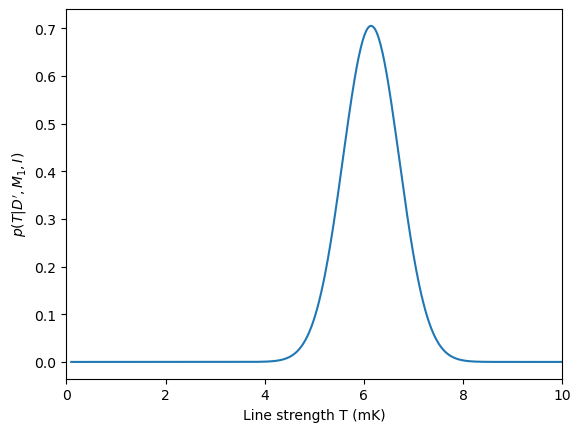


Total of 0 test failures


In [17]:
T, p_T_sim = calculate_m1alt_T_posterior(nu, sim)

print(f'Maximum posterior is at T = {T[np.argmax(p_T_sim)]:.2f} mK')

# The function you wrote above should work again here.
plot_T_posterior(T, p_T_sim)
plt.show()

### BEGIN HIDDEN TESTS
nfail = 0

# Check T values
with log_assert():
    assert np.all(T[:-1] < T[1:]), ('T is not sorted', T)
# Should at least span from 4 to 6, since right answer is 5.
with log_assert():
    assert T[0] <= 4, T[0]
with log_assert():
    assert T[-1] >= 6, T[-1]

# Check each function separately.
Tmax = T[np.argmax(p_T_sim)]
B = 0.2 # Arbitrary
nu0 = 37
sigL = 2
true_S = B + Tmax*np.exp(-((nu-nu0)**2)/(2*sigL**2))
S = model1alt(nu, B, Tmax)
with log_assert():
    assert np.allclose(S, true_S), S
    
true_pDBT = np.exp(-np.sum((sim - model1alt(nu, B, Tmax))**2 / 2))
true_pDBT /= (2.*np.pi)**(len(sim)/2)
pDBT = calculate_m1alt_likelihood_B_T(nu, sim, B, Tmax, sigma=1)
with log_assert():
    assert np.allclose(pDBT, true_pDBT, atol=0), (pDBT, true_pDBT)

# Make sure they actually coded up correctly with sigma, not just assumed 1.
sigma = 2.3
true_pDBT = np.exp(-np.sum((sim - model1alt(nu, B, Tmax))**2 / (2*sigma**2)))
true_pDBT /= (2.*np.pi*sigma**2)**(len(sim)/2)
pDB = calculate_m2alt_likelihood_B(nu, sim, Bmax, sigma=sigma)
with log_assert():
    assert np.allclose(pDB, true_pDB, atol=0), (pDB, true_pDB)

# Use some other range for B to test B marginalization.
B = np.linspace(-5, -1, 100)
pB = np.ones_like(B) / 4
pDBT = np.empty(B.shape)
for j, Bi in enumerate(B):
    pDBT[j] = calculate_m1alt_likelihood_B_T(nu, sim, Bi, Tmax)
true_pDT = np.trapz(pDBT * pB, B)
pDT = calculate_m1alt_likelihood_T(nu, sim, Tmax, B, pB)
with log_assert():
    assert np.allclose(pDT, true_pDT, atol=0), (pDT, true_pDT)

# And finally test the parameter esimation using a different range of T
Tx, pTD = calculate_m1alt_T_posterior(nu, sim, Tmin=10, Tmax=15, Bmin=-5, Bmax=-1)
pT = np.ones_like(Tx) / (Tx * np.log(15/10))
# In case they returned a T range that is larger than the prior:
pT[Tx<10] = 0
pT[Tx>15] = 0
pDT = np.empty(Tx.shape)
for i, Ti in enumerate(Tx):
    pDT[i] = calculate_m1alt_likelihood_T(nu, sim, Ti, B, pB)
true_pTD = pDT * pT
true_pTD /= np.trapz(true_pTD, Tx)
with log_assert():
    # This might not match to super high precision because it depends on
    # their number of B values, so only test to 1% agreement.  (Hopefully safe?)
    assert np.allclose(pTD, true_pTD, rtol=0.01, atol=0), (pTD, true_pTD)

print(f"\nTotal of {nfail} test failures")
assert nfail == 0
### END HIDDEN TESTS

In [18]:
# Question 3c

def calculate_sim_odds_alt(nu, signal, sigma=1, Tmin=0.1, Tmax=100, Bmin=-10, Bmax=10):
    """Calculate the odds ration of the simulation for the alternate models M1' vs M2',
    assuming Gaussian noise, a Jeffreys prior on T, and a uniform prior on B.
    
    Returns O_1'2' = p(D'|M1',I) / p(D'|M2',I)
    """
    
    ### BEGIN SOLUTION
    # Calculate priors
    B = np.linspace(Bmin, Bmax, 100)
    pB = np.ones_like(B) / (Bmax-Bmin)

    T = np.linspace(Tmin, Tmax, 5000)
    pT = np.ones_like(T) / (T * np.log(Tmax/Tmin))

    # Calculate p(D|M1',T)
    pDT = np.empty(T.shape)
    for i, Ti in enumerate(T):
        pDT[i] = calculate_m1alt_likelihood_T(nu, signal, Ti, B, pB, sigma=sigma)

    # Integrate to get p(D|Mi')
    pM1 = np.trapz(pDT * pT, T)
    
    # Calculate p(D|M2',B)
    pDB = np.empty(B.shape)
    for i, Bi in enumerate(B):
        pDB[i] = calculate_m2alt_likelihood_B(nu, signal, Bi, sigma=sigma)    

    # Integrate to get p(D|M2')
    pM2 = np.trapz(pDB * pB, B)

    return pM1 / pM2
    ### END SOLUTION

In [19]:
odds_alt_sim = calculate_sim_odds_alt(nu, sim)
print(f'The new odds are {odds_alt_sim:.2e}')

### BEGIN HIDDEN TESTS
nfail=0

# Should be less than what we got without B in the models.
with log_assert():
    assert odds_alt_sim < odds_sim

print(f"\nTotal of {nfail} test failures")
assert nfail == 0
### END HIDDEN TESTS

The new odds are 6.25e+24

Total of 0 test failures
